In [2]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np

import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# ARIMA model and autocorrelation plots
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

This cell constructs a Series called y that contains the target feature - in this case, hourly electricity demand.

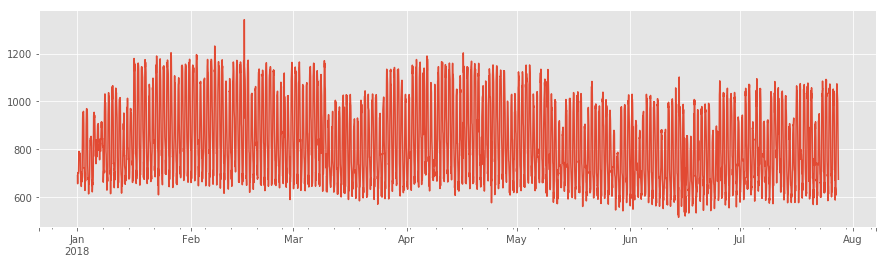

In [3]:
# read clean electricity data to create target variable array y
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

# remove Davenport for now because it is missing most of June and July
elec.drop('Davenport',axis=1,inplace=True)

# sum the remaining buildings
y = pd.Series(elec.iloc[:, 0:11].sum(axis=1))

y.plot(figsize=(15,4))

### Hour of week AND week of year transformer

This transformer calculates the hour of week average (array of 168 values). This captures the weekend and weekday variations at the hourly level. Then, to catch effects like winter and spring break, the week of the year average is transformed out.

As of now, this transformer is performing the best.

In [4]:
# create a dummy dataframe to handle complicated time operations
df = pd.DataFrame(y,columns=['demand'],index=y.index)
df['hourofweek'] = y.values

k=1
for i in range(len(df)):
    df['hourofweek'][i] = k
    k = k+1
    if k == 168: k=0
avg_hourofweek = y.groupby(df['hourofweek']).mean()
df['avg_hourofweek'] = df['hourofweek'].map(avg_hourofweek)

hourofweek_mean = df['avg_hourofweek'].values

# week of year calculation is easily built in to pandas
weekofyear_mean = y.index.weekofyear.map(y.groupby(y.index.weekofyear).mean()).values

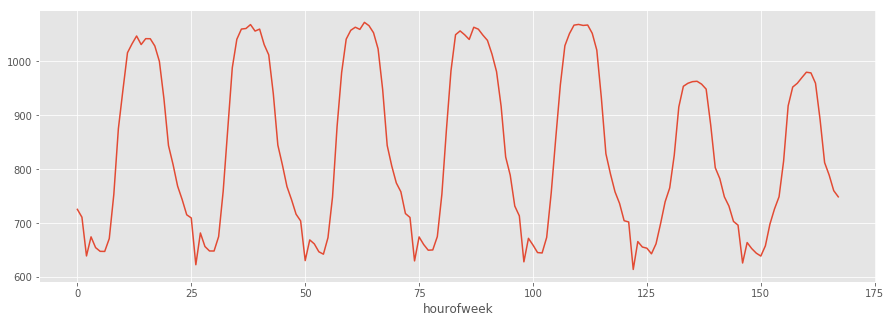

In [5]:
avg_hourofweek.plot(figsize=(15,5))

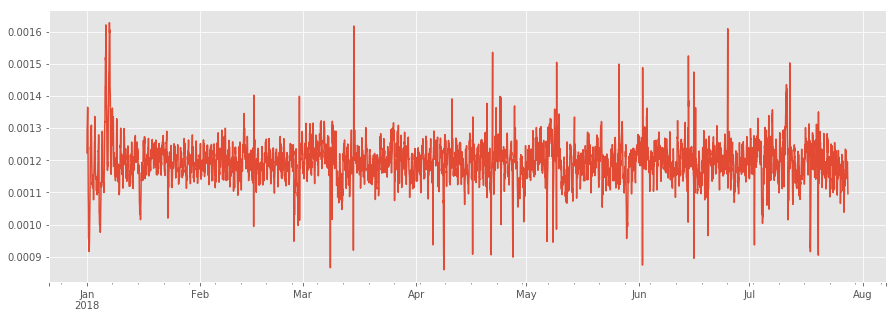

In [6]:
# combine both week of year and hourofweek effects to identity
y_trans = (y/weekofyear_mean)
y_trans = (y_trans/hourofweek_mean)

y_trans.plot(figsize=(15,5))

In [7]:
# export results to csv, to untransform, multiply by hourofweek_mean, then weekofyear_mean
transformers = pd.DataFrame({'demand':y,'weekofyear_trans':weekofyear_mean,'hourofweek_trans':hourofweek_mean})
# transformers.to_csv('../data/elec_transformations.csv')

## Plots for export

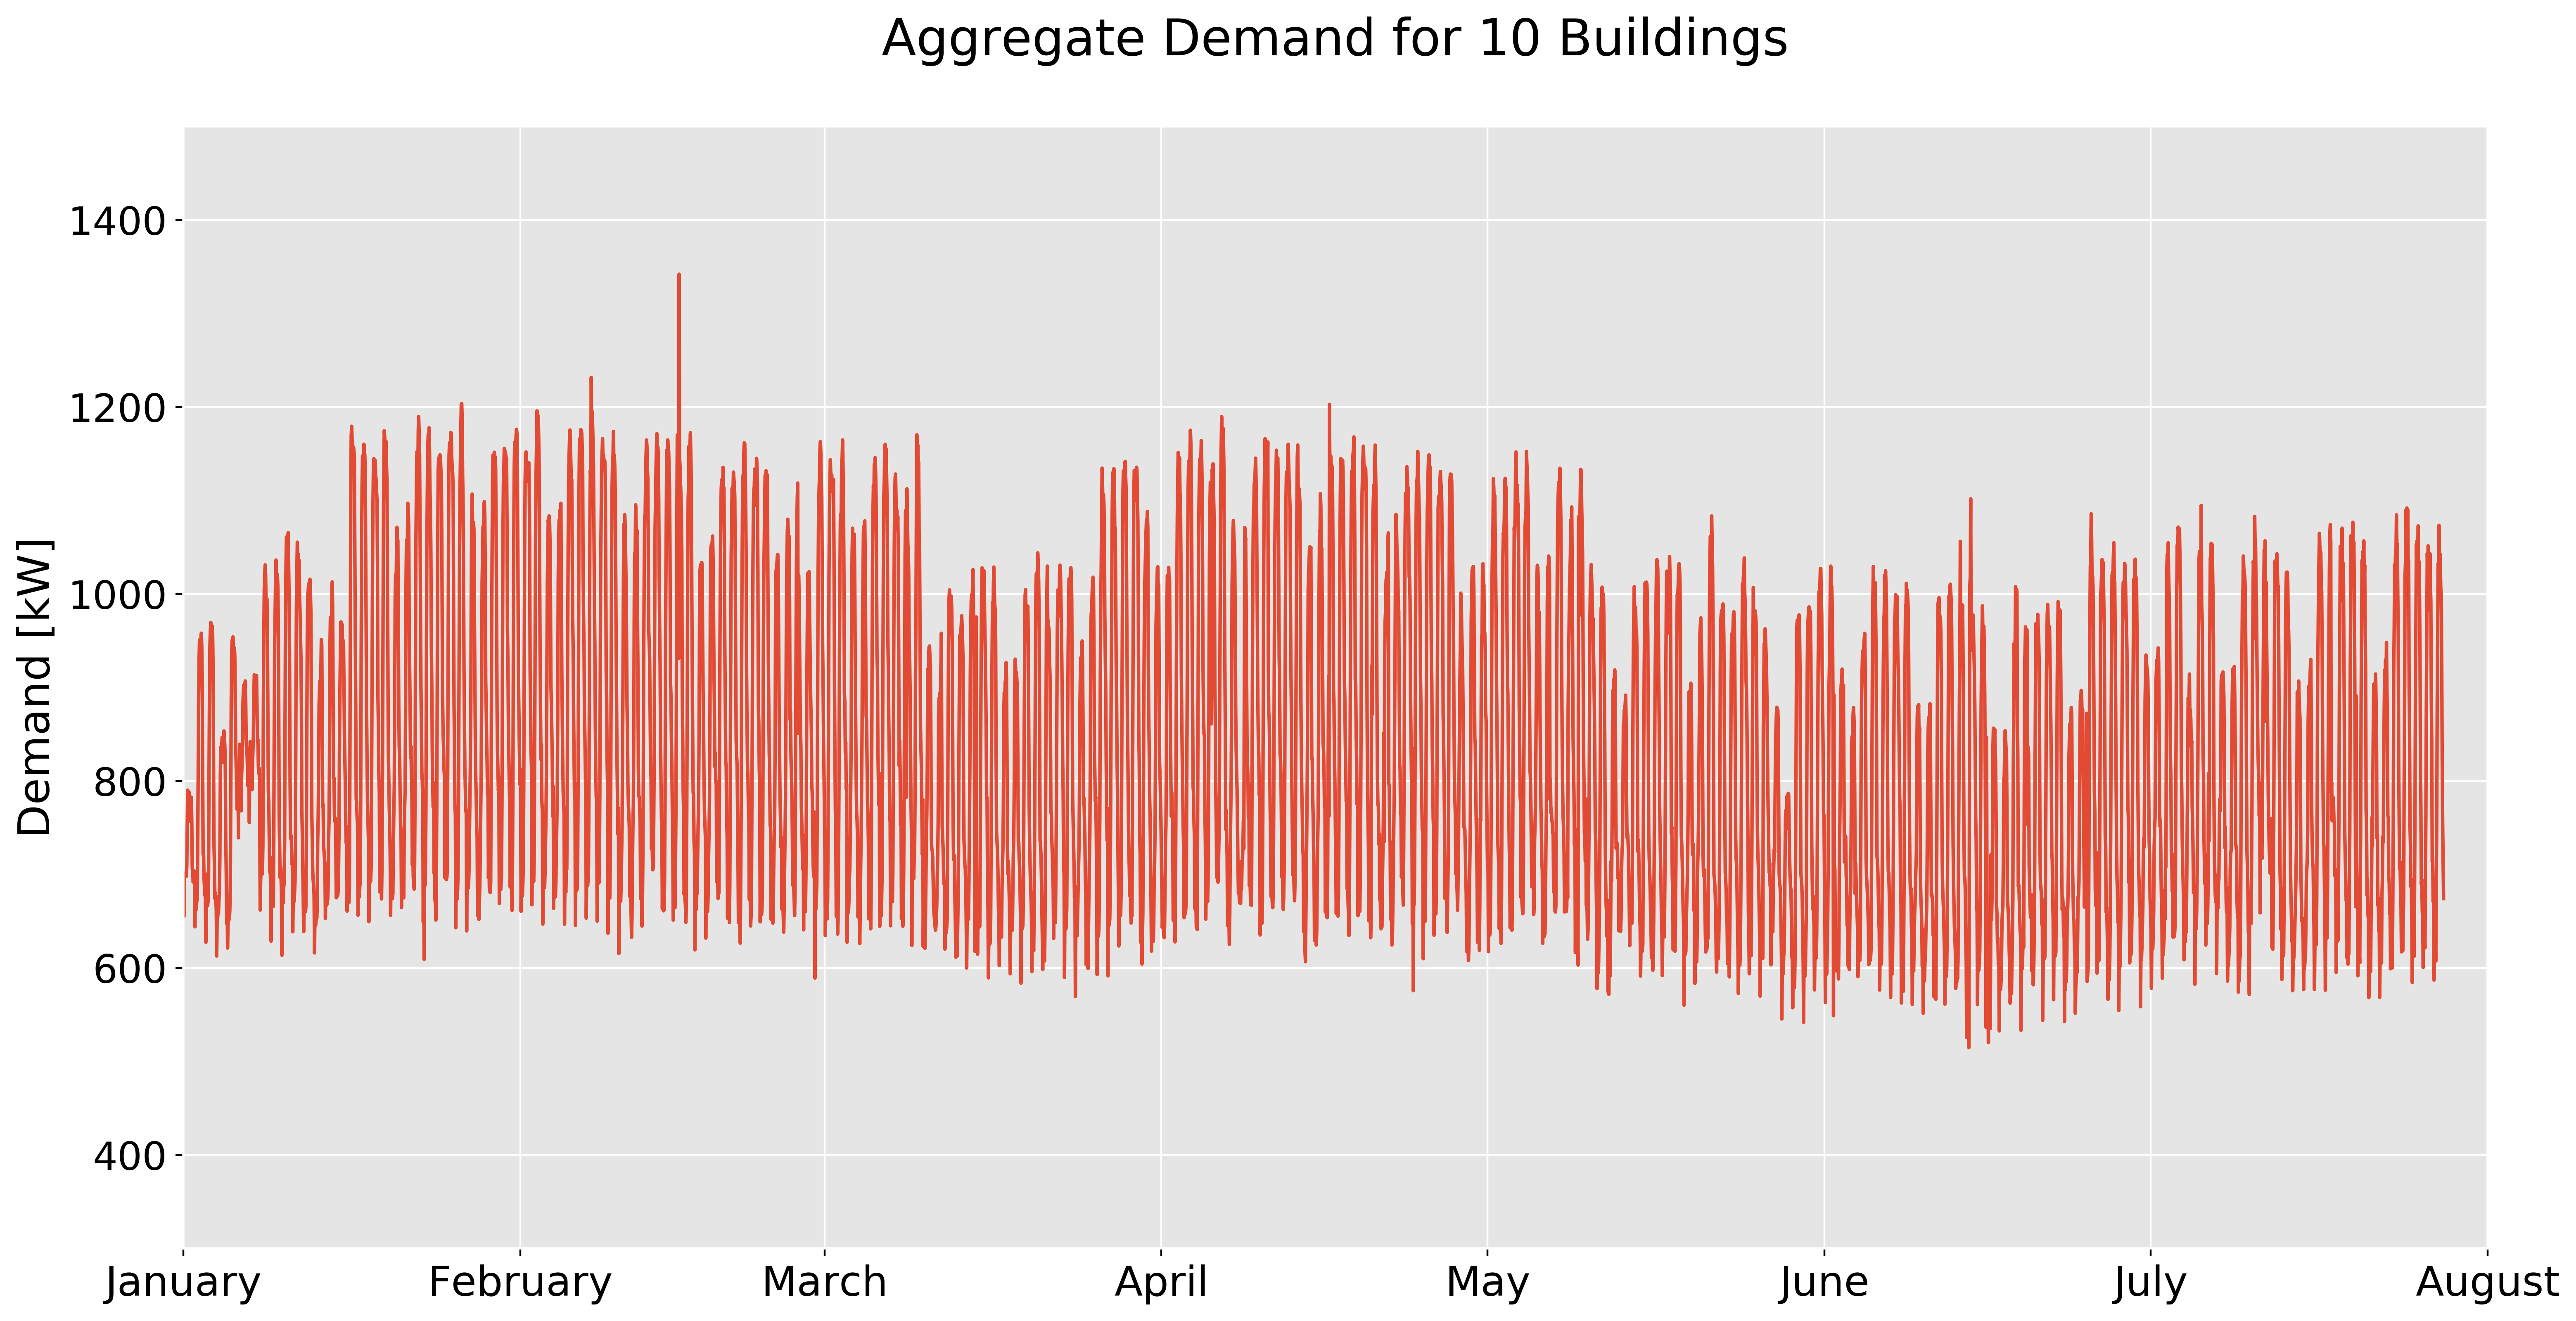

In [8]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,9),dpi=400)

plt.title('Aggregate Demand for 10 Buildings\n',color='k',size=22)

ax.plot(y.index,y.values)

ax.set_ylabel('Demand [kW]',color='k',size=19)
ax.set_ylim(300,1500)

ax.set_xlim(736695, 736907)
x_tick_labels = ['January','February','March','April','May','June','July','August']
ax.set_xticklabels(x_tick_labels)

ax.tick_params(axis='x',colors='k',labelsize=18)
ax.tick_params(axis='y',colors='k',labelsize=17)

fig.savefig('../figures/transform_original.png', bbox_inches='tight')

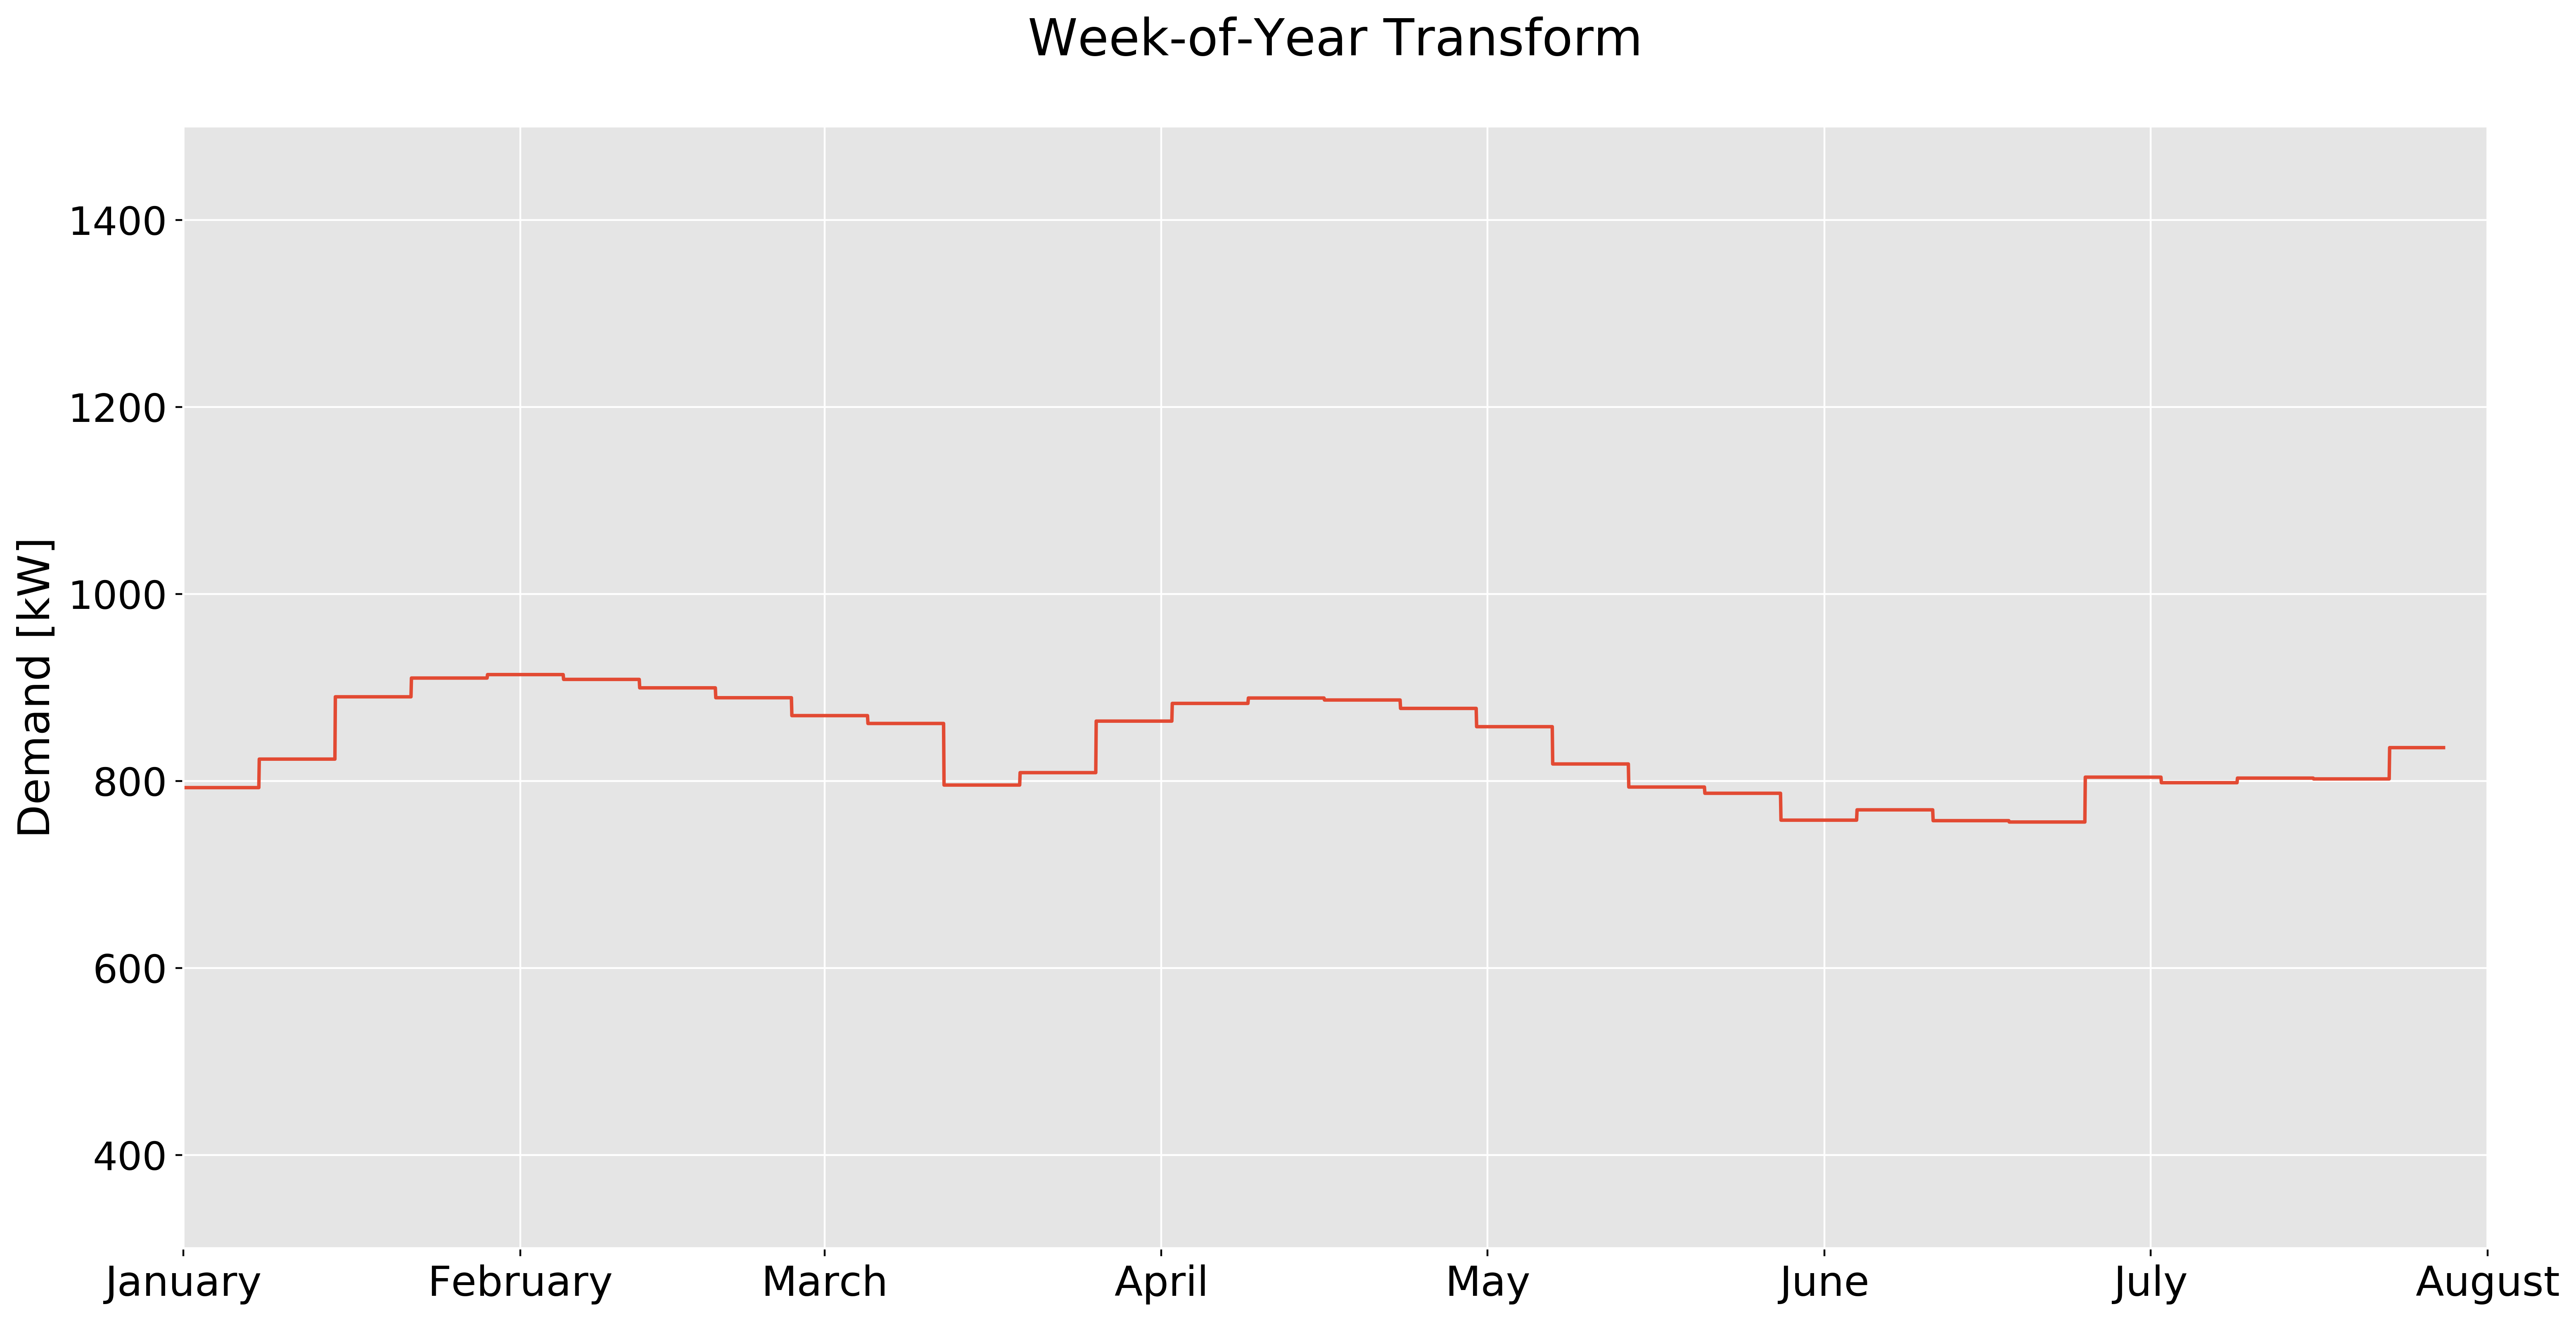

In [9]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,9),dpi=400)

plt.title('Week-of-Year Transform\n',color='k',size=22)
ax.plot(elec.index,weekofyear_mean)

ax.set_ylim(300,1500)
ax.set_ylabel('Demand [kW]',color='k',size=19)

ax.set_xlim(736695, 736907)
x_tick_labels = ['January','February','March','April','May','June','July','August']
ax.set_xticklabels(x_tick_labels)

ax.tick_params(axis='x',colors='k',labelsize=18)
ax.tick_params(axis='y',colors='k',labelsize=17)

fig.savefig('../figures/transform_weekofyear.png', bbox_inches='tight')

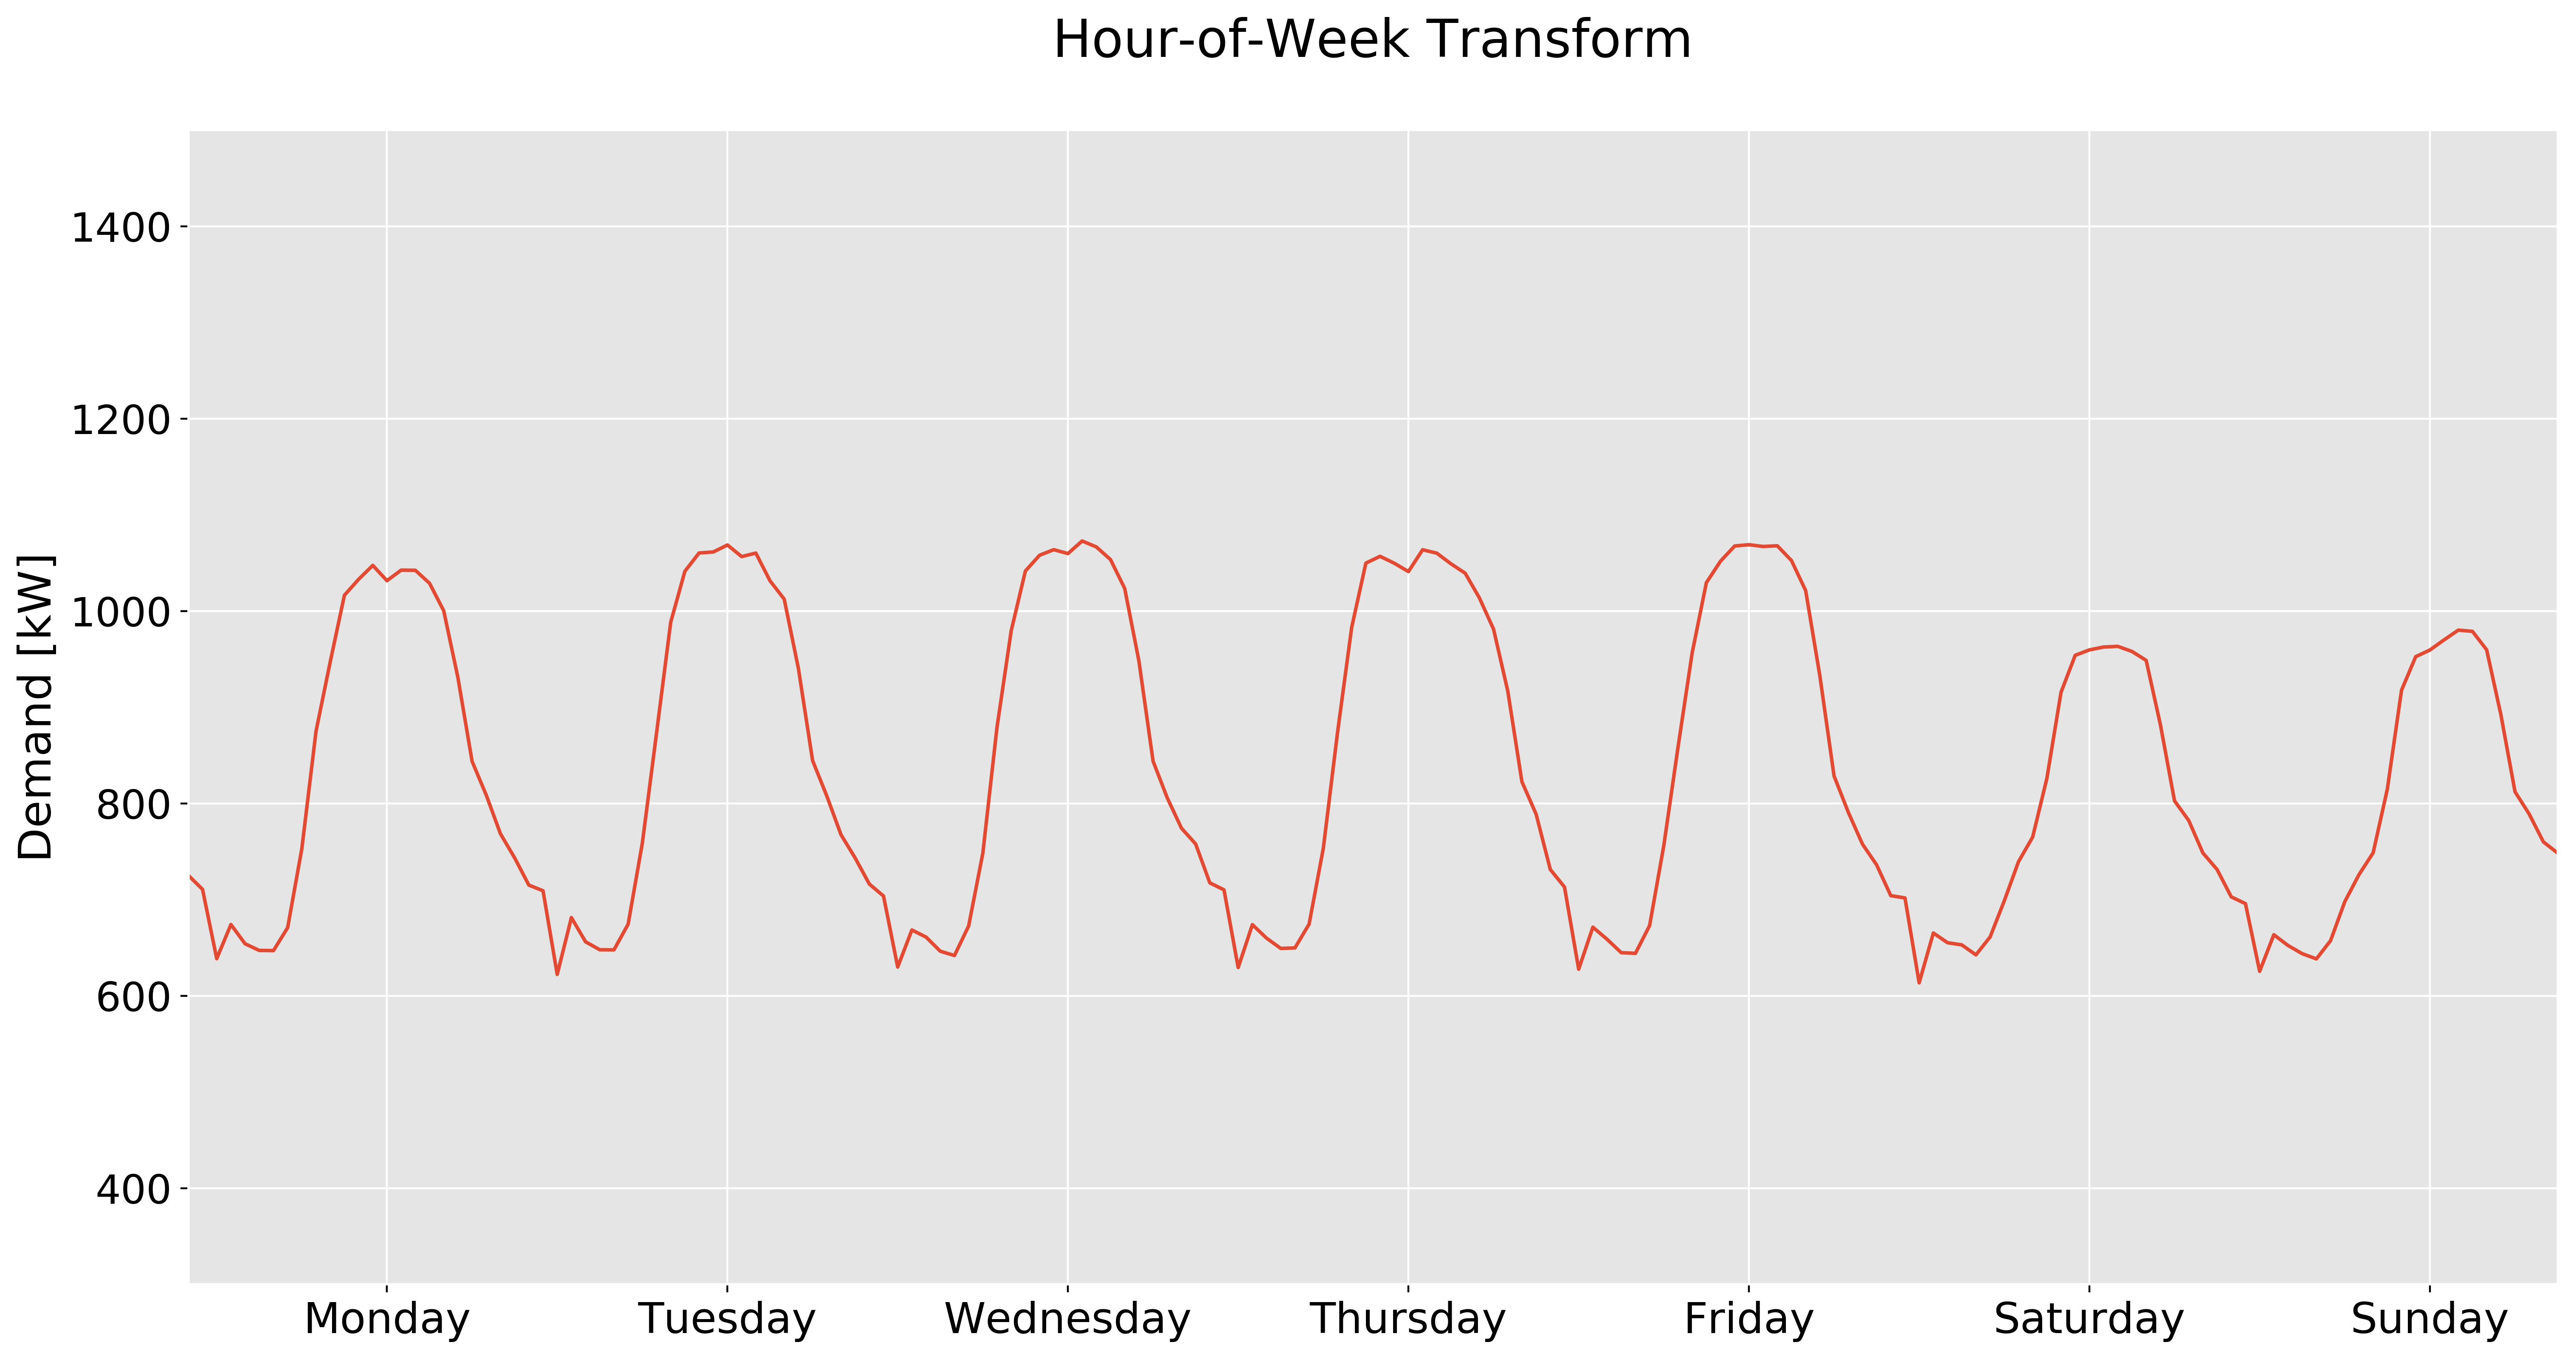

In [10]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,9),dpi=400)

plt.title('Hour-of-Week Transform\n',color='k',size=22)

x_ticks = np.arange(14,175,24)
x_labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.xticks(x_ticks,x_labels,color='k')
plt.xlim(0,167)

ax.plot(avg_hourofweek)

ax.set_ylabel('Demand [kW]',color='k',size=19)
ax.set_ylim(300,1500)

ax.tick_params(axis='x',colors='k',labelsize=18)
ax.tick_params(axis='y',colors='k',labelsize=17)

fig.savefig('../figures/transform_hourofweek.png', bbox_inches='tight')

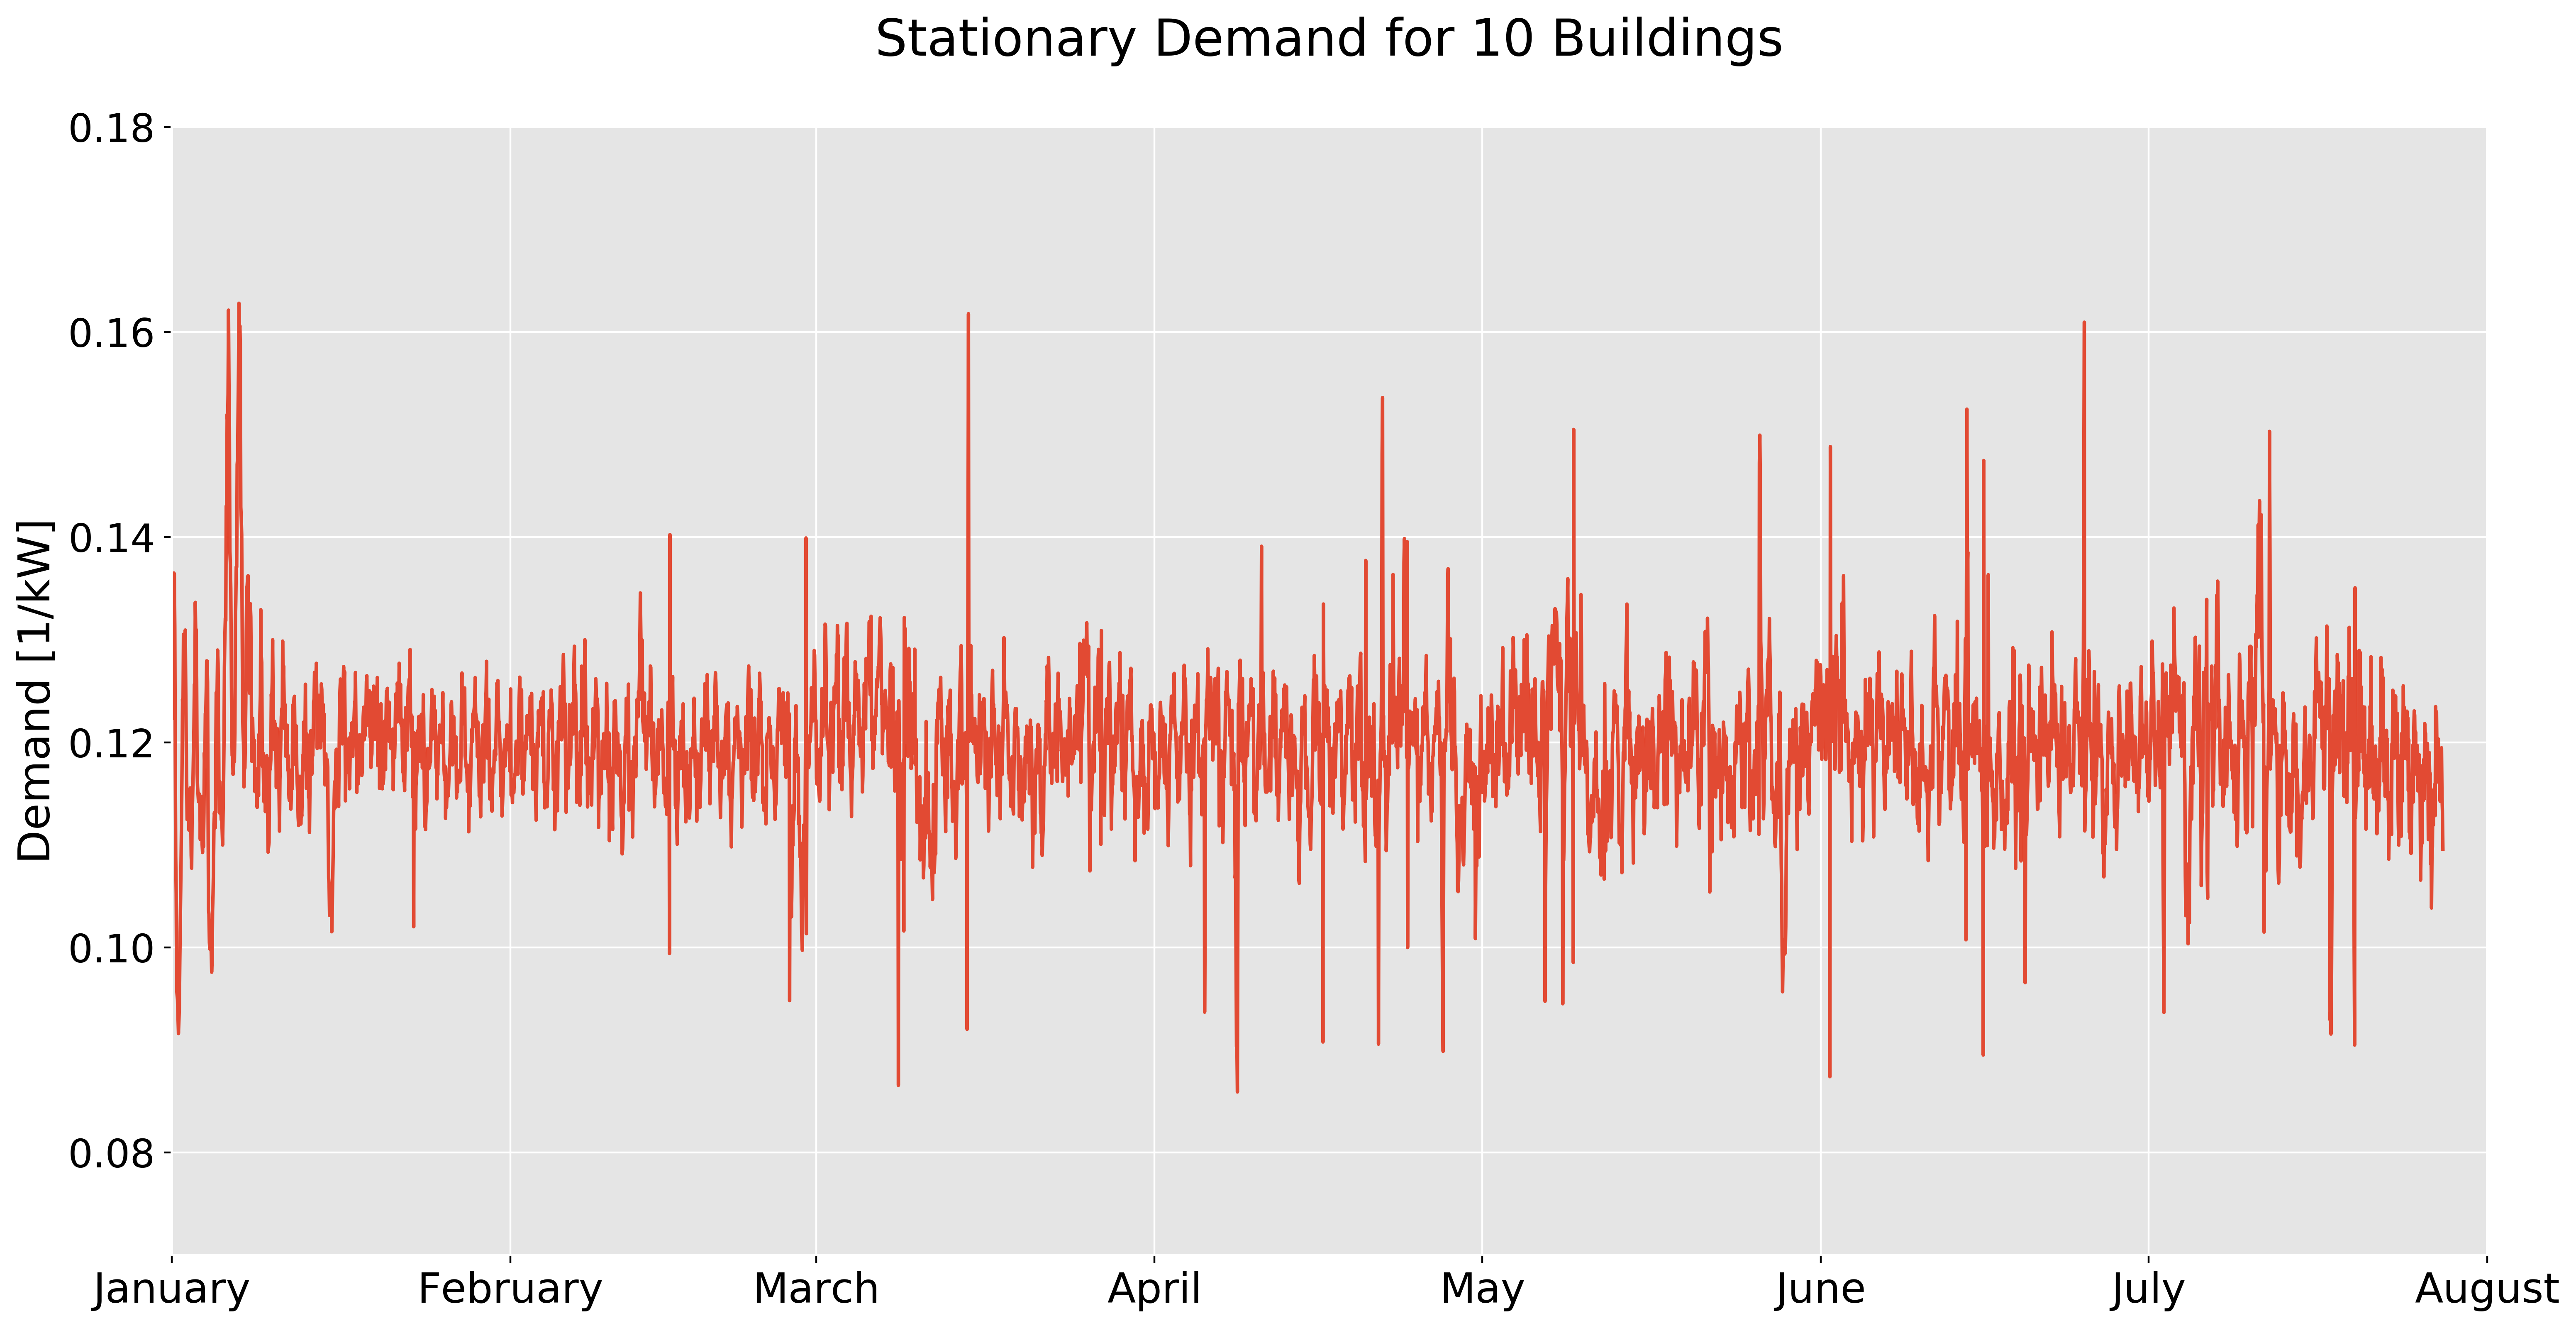

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,9),dpi=400)

plt.title('Stationary Demand for 10 Buildings\n',color='k',size=22)

ax.plot(elec.index,y_trans.values*100)

ax.set_ylabel('Demand [1/kW]',color='k',size=19)
ax.set_ylim(0.07,0.18)

ax.set_xlim(736695, 736907)
x_tick_labels = ['January','February','March','April','May','June','July','August']
ax.set_xticklabels(x_tick_labels)

ax.tick_params(axis='x',colors='k',labelsize=18)
ax.tick_params(axis='y',colors='k',labelsize=17)

fig.savefig('../figures/transform_stationary.png', bbox_inches='tight')

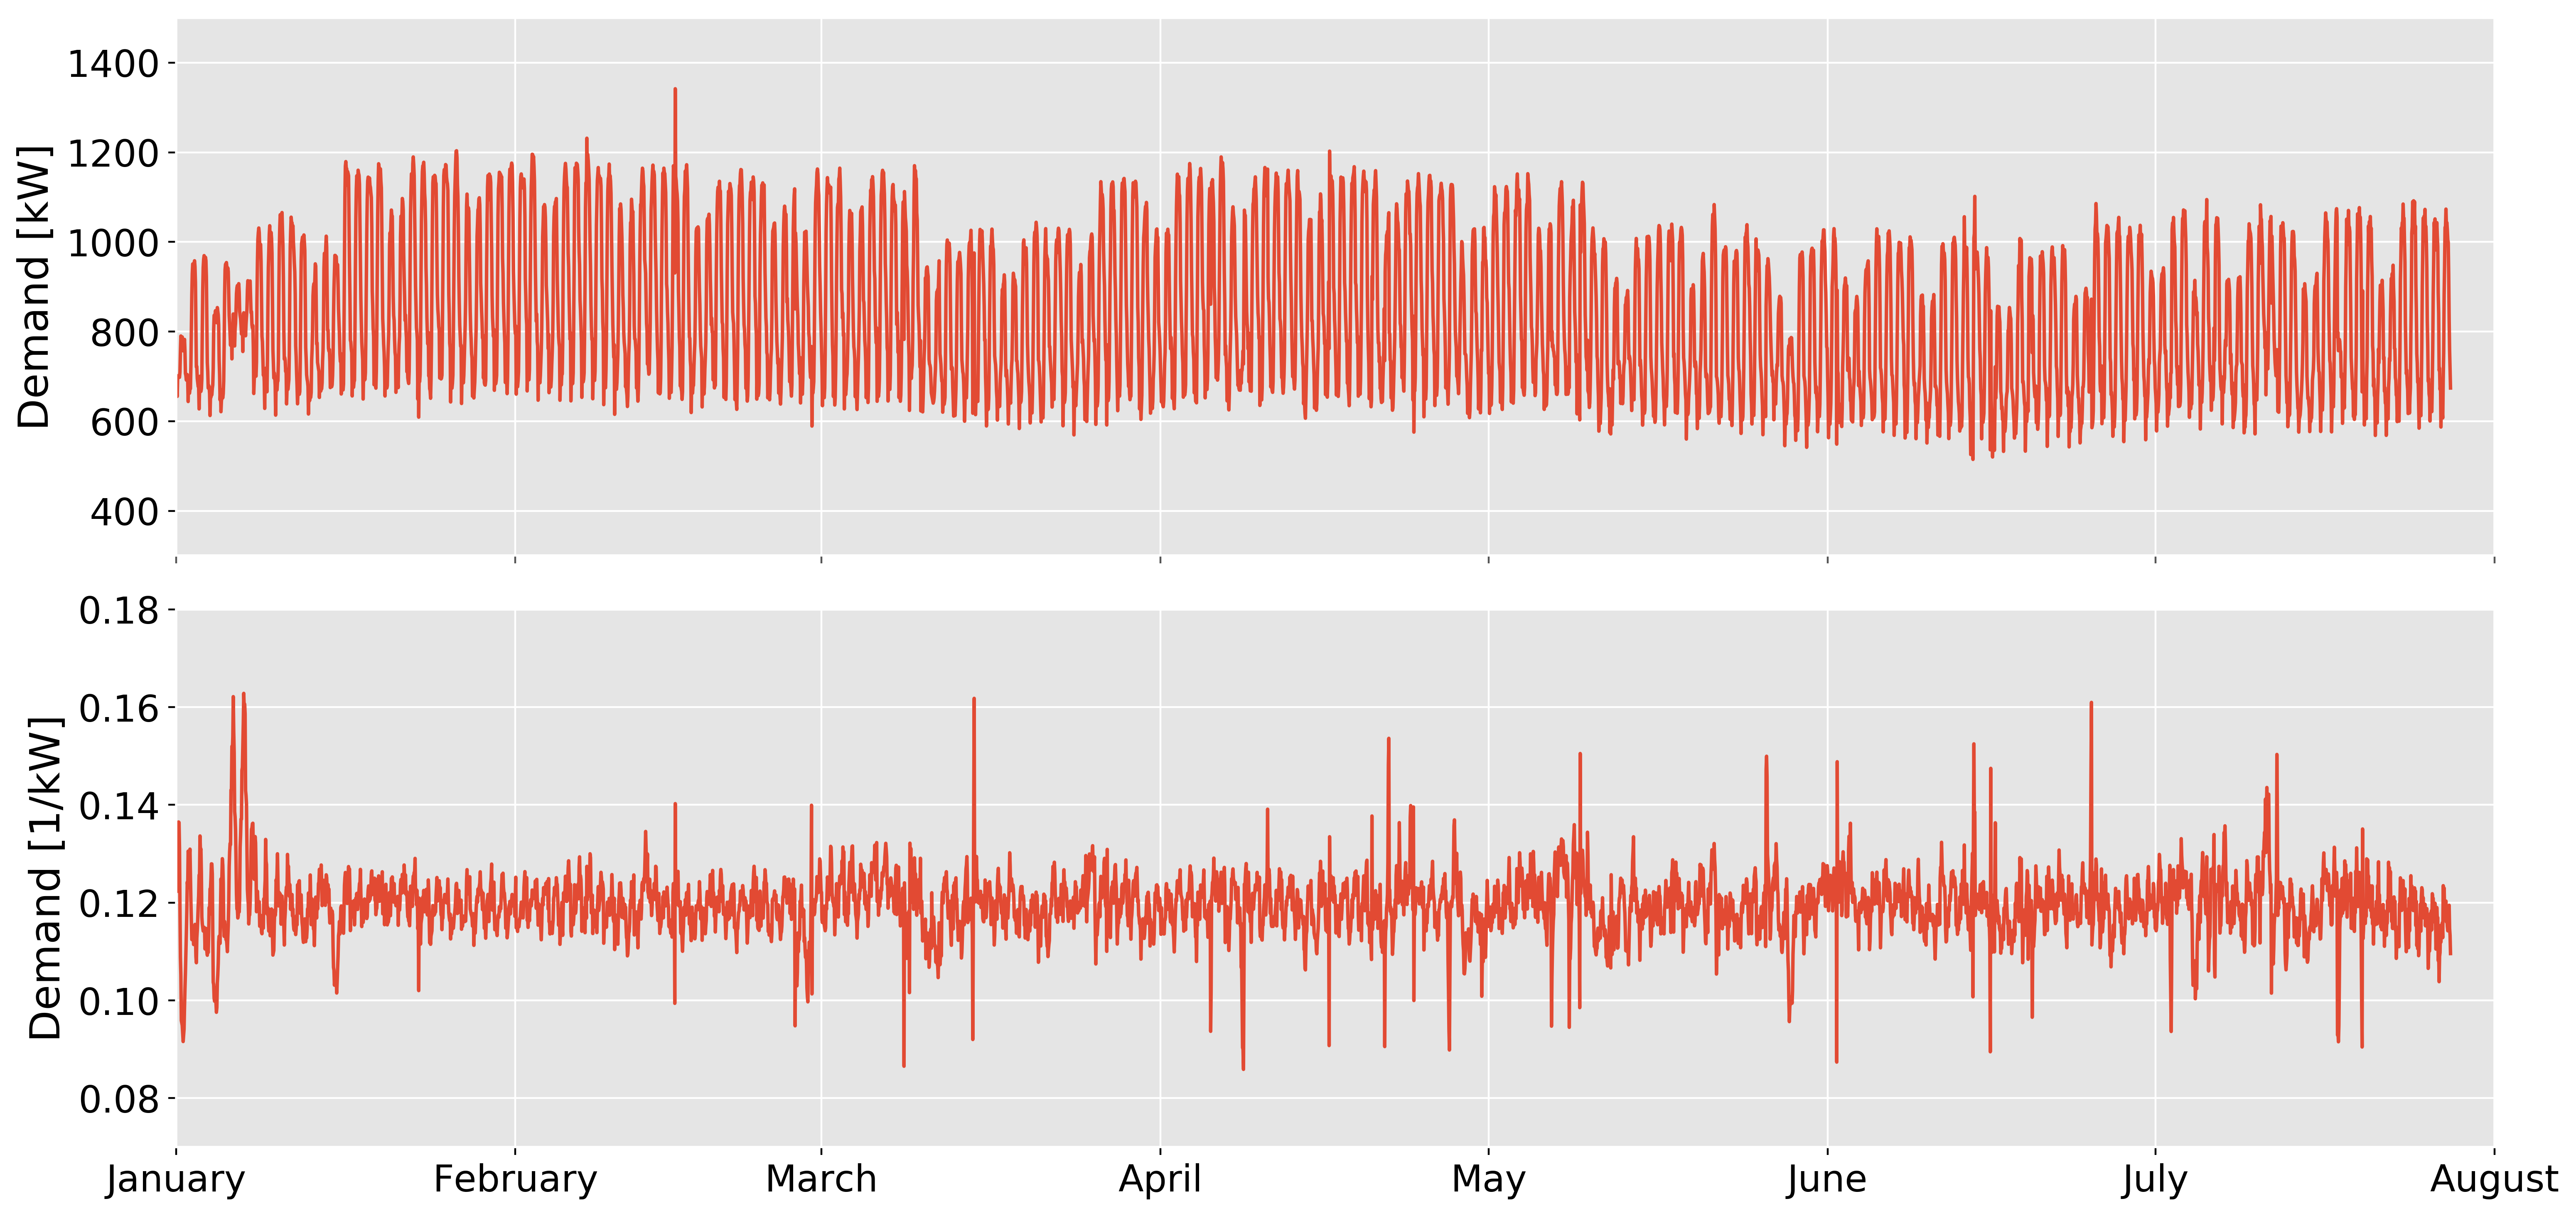

In [12]:
fig, [ax1,ax2] = plt.subplots(nrows=2,ncols=1,figsize=(18,9),dpi=400,sharex=True)

fig.subplots_adjust(hspace=0.1)

ax1.plot(y.index,y.values)
ax1.set_ylabel('Demand [kW]',color='k',size=18)
ax1.set_ylim(300,1500)
ax1.tick_params(axis='y',colors='k',labelsize=16)

ax2.plot(y.index,y_trans.values*100)
ax2.set_ylabel('Demand [1/kW]',color='k',size=18)
ax2.set_ylim(0.07,0.18)
ax2.tick_params(axis='y',colors='k',labelsize=16)

ax2.set_xlim(736695, 736907)
x_tick_labels = ['January','February','March','April','May','June','July','August']
ax2.set_xticklabels(x_tick_labels)
ax2.tick_params(axis='x',colors='k',labelsize=16)

fig.savefig('../figures/transform_comparison.png', bbox_inches='tight')